In [6]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.summarization import keywords
from gensim.summarization import summarize
from summarization import Summarizer
import pickle

In [ ]:
#SKIP
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
#https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [ ]:
#SKIP
summarizer = Summarizer("sample3")
sums = summarizer.summarize_all()
files = summarizer.files 

for sum in sums:
    print(len(sum))

corpus = []
d = dict()

i = 0
for sum in sums:
    for x in sum:
        corpus.append(x)
        d[x] = i
        i+=1
        
print("\n",len(corpus))
pickle.dump(corpus, open("corpus.p", "wb" ))
pickle.dump(files, open("files.p", "wb" ))
pickle.dump(sums, open("sums.p", "wb" ))
pickle.dump(d, open("d.p", "wb" ))

In [2]:
corpus = pickle.load(open("corpus.p", "rb" ) )
model_small = pickle.load(open("model.p", "rb" ) )
data = []
for sentence in corpus:
    sentence = sentence.lower().split()
    #res = []
    res = 0
    n = 0
    for word in sentence:
        try:
            #model_small[word]=model[word]
            res+=model_small[word]
            #res.append(model[word])
            n+=1
        except:
            pass
    res/=n
    #print(n)
    #for i in range(50-n):
    #    res.append([0]*300)
    res = np.array(res)
    #print(res.shape)
    data.append(res.reshape(-1))
    
data = np.array(data)
pickle.dump(data, open( "data.p", "wb" ) )
#pickle.dump(model_small, open( "model.p", "wb" ) )

But there are people who pretend to be patriot but do anything for their own interest even at the cost of their native country.


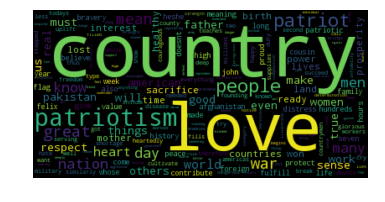

He is called a true patriot who loves his coun­try and is ready to sacrifice his all for her cause, and whole­heartedly works for the welfare of his motherland.


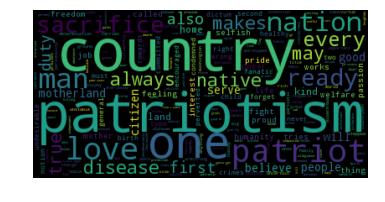

One who is a true patriot is ready to sacrifice his all for his native country.


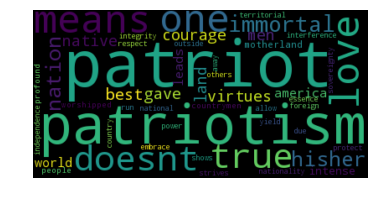

In [3]:
data = pickle.load(open("data.p", "rb" ) )
NUM_CLUSTERS = 3

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=euclidean_distance, repeats=100) #euclidean_distance #cosine_distance
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(kclusterer.means())

import re
from collections import Counter
for j in range(NUM_CLUSTERS):
    cluster = [corpus[i] for i in range(len(corpus)) if assigned_clusters[i]==j]

    text = []
    for i in range(len(cluster)):
        sentense = str(cluster[i]).lower().split(" ")
        for word in sentense:
            text.append(re.sub(r'[^\w\s]','',str(word)))
    cnt = Counter(text)
    f = open("cluster_"+str(j)+".txt", 'w')
    for item in text:
        f.write("%s\n" % item)
    f.close()
    
    text = open("cluster_"+str(j)+".txt").read()
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    m = 100
    l = 0
    for k in range(len(data)):
        t = euclidean_distance(data[k], kclusterer.means()[j])
        if t<m:
            m=t
            l=k
    print(corpus[l])
    plt.show()

In [4]:
weights = [0.5,-0.1, 0.3]

In [5]:
files = pickle.load(open("files.p", "rb" ) )
sums = pickle.load(open("sums.p", "rb" ) )
d = pickle.load(open("d.p", "rb" ) )
i = 0
for essay in sums:
    res = 0
    for sentance in essay:
        k = assigned_clusters[d[sentance]]
        #print(k)
        res+= weights[k]
    print(files[i], round(res,1))
    i+=1

03-Essay01 2.4
03-Essay02 4.6
03-Essay03 3.6
03-Essay04 4.3
03-Essay05 2.4
03-Essay06 0.3
03-Essay07 2.9
03-Essay08 2.3
03-Essay09 3.9
